In [106]:
from huggingface_hub import hf_hub_download
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [142]:
# iters = list(range(0, 200, 10)) + list(range(200, 1200, 20)) + list(range(1200, 10_001, 50)) + list(range(10_250, 20_001, 250))
iters = (
    list(range(0, 200, 10))
    + list(range(200, 1200, 20))
    + list(range(1200, 5_001, 50))
    + list(range(5_100, 10_001, 100))
    + list(range(10_500, 25_501, 500))
    + list(range(26_000, 99_001, 1000))
)
run_name = "3i23qszs"
llc_files = [hf_hub_download(
    f"cybershiptrooper/ConceptPerlocation_{run_name}_ckpts",
    repo_type="model",
    filename=f"llc/llc_output_it_{it}.pkl",
    revision="main",
    local_dir=f"./cache/{run_name}",
) for it in tqdm(iters)]

100%|██████████| 302/302 [01:18<00:00,  3.83it/s]


In [143]:
llcs = []
for file in llc_files:
    with open(file, "rb") as f:
        data = pickle.load(f)
        llcs.append(data)

In [144]:
llcs[0].keys()

dict_keys(['init_loss', 'llc/means', 'llc/stds', 'llc/trace', 'loss/trace'])

In [145]:
llcs[0]["llc/trace"].shape

(5, 100)

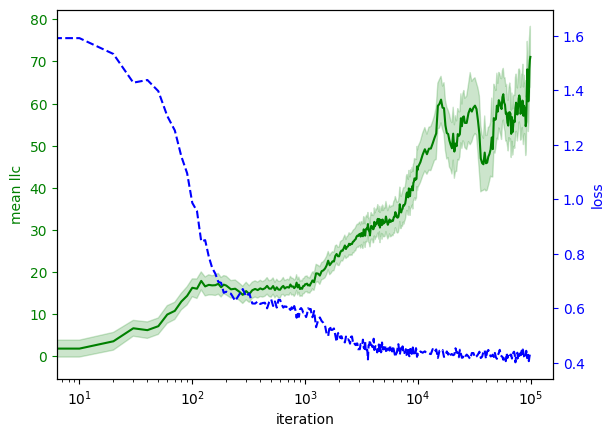

In [146]:
x = iters
y = [llc["llc/means"].mean() for llc in llcs]
y_err = [llc["llc/stds"].mean() for llc in llcs]
y_loss = [llc["init_loss"] for llc in llcs]
# plt.plot(x, y)

# plot x and y_loss with a scale on the right side
fig, ax1 = plt.subplots()
ax1.plot(x, y, 'g-')
#fill between
ax1.fill_between(x, [y[i] - y_err[i] for i in range(len(y))], [y[i] + y_err[i] for i in range(len(y))], color='g', alpha=0.2)
ax1.set_xlabel('iteration')
ax1.set_ylabel('mean llc', color='g')
ax1.tick_params('y', colors='g')

ax2 = ax1.twinx()
ax2.plot(x, y_loss, 'b--')
ax2.set_ylabel('loss', color='b')
ax2.tick_params('y', colors='b')

# set x axis to log scale
plt.xscale('log')
# plt.xlim([10, 1200])

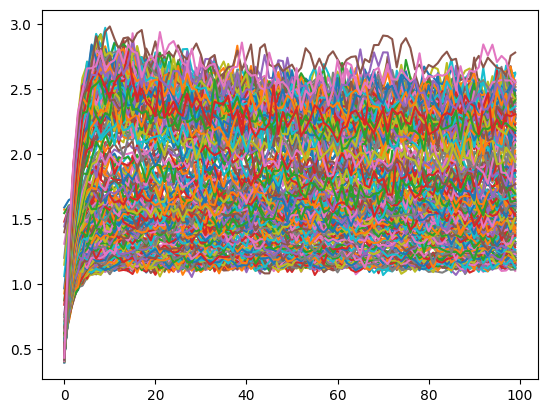

In [152]:
llc_traces = [llc["loss/trace"] for llc in llcs[:-5]]
# meaned_traces = llc_traces.mean(axis=1)
meaned_traces = [np.mean(llc_traces, axis=0) for llc_traces in llc_traces]

for trace in meaned_traces:
    plt.plot(trace)
    # plt.legend(iters, loc='center left', bbox_to_anchor=(1, 0.5))

2.3240006 +/- 0.30852056


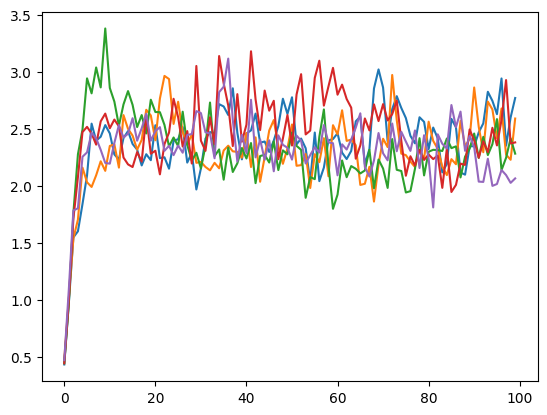

In [163]:
idx = -30
for trace in llc_traces[idx]:
    plt.plot(trace)

print(llc_traces[idx][-1].mean(), "+/-", llc_traces[idx][-1].std())

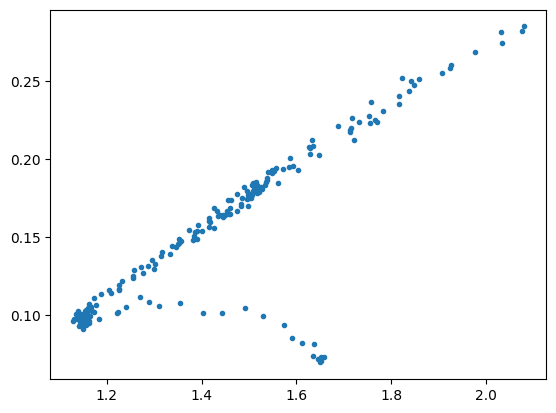

In [149]:
plt.scatter(
    [llc_traces[idx].mean(axis = -1).mean() for idx in range(len(llc_traces))],
    [llc_traces[idx].std(axis = -1).mean() for idx in range(len(llc_traces))],
    marker='.',
)